In [1]:
from keras.layers import Conv2D, MaxPooling2D , Activation, Dropout, BatchNormalization, Flatten, Dense,AveragePooling2D
from sklearn.metrics import confusion_matrix,precision_score,recall_score,classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.callbacks import ModelCheckpoint ,ReduceLROnPlateau ,EarlyStopping
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn
import pathlib 
import random
import cv2
import os

<a id='wrangling'></a>
## Data Wrangling

### General Properties

<a id='wranglingChest'></a>
## Dataset Of faces

In [2]:
#data_dir = "/content/drive/MyDrive/dataset1.zip"
#with zipfile.ZipFile(data_dir,"r") as z:
#    z.extractall(".")
drive.mount('/content/drive')
data_dir=pathlib.Path('/content/drive/MyDrive/dataset/faces2d/data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def laod_images_opencv_extisions(path):
    ext = [".jpg",".gif",".png",".tga",'.*']   # Add image formats here
    files = []
    [files.extend(data_dir.glob(path + '/*' + e)) for e in ext]
    return files


In [4]:
classes=[]
for x in os.walk('/content/drive/MyDrive/dataset/faces2d/data'):
    print(x[0])
    print(x[0].split('/'))
    print(x[0].split('/')[-1])
    classes.append(x[0].split('/')[-1])
    print('***********************************************************')

classes = classes[1:]
print(classes)

/content/drive/MyDrive/dataset/faces2d/data
['', 'content', 'drive', 'MyDrive', 'dataset', 'faces2d', 'data']
data
***********************************************************
/content/drive/MyDrive/dataset/faces2d/data/prognathic
['', 'content', 'drive', 'MyDrive', 'dataset', 'faces2d', 'data', 'prognathic']
prognathic
***********************************************************
/content/drive/MyDrive/dataset/faces2d/data/normal
['', 'content', 'drive', 'MyDrive', 'dataset', 'faces2d', 'data', 'normal']
normal
***********************************************************
/content/drive/MyDrive/dataset/faces2d/data/retrognathic
['', 'content', 'drive', 'MyDrive', 'dataset', 'faces2d', 'data', 'retrognathic']
retrognathic
***********************************************************
['prognathic', 'normal', 'retrognathic']


In [5]:
classes= [i.split('/')[-1] for i in [x[0] for x in os.walk('/content/drive/MyDrive/dataset/faces2d/data')][1:]]
image_dir={}
for i in classes:
    image_dir[i]=laod_images_opencv_extisions(i)


In [6]:
le=LabelEncoder()
def get_dataFrame(dic):
    x,y=[],[]
    for imageName, imagePaths in dic.items():
        for img in imagePaths:
            try:
                x.append(img)
                y.append(imageName)
            except:
                continue 
            
    dataFrame = pd.DataFrame({
        'filename': x,
        'category': y
    })
    dataFrame['category']=le.fit_transform(dataFrame['category'])
    dataFrame['category'] = dataFrame['category'].astype('string')
    dataFrame['filename'] = dataFrame['filename'].astype('string')
    dataFrame=dataFrame.sample(frac=1)
    return dataFrame

In [7]:
train_data_frame=pd.DataFrame(get_dataFrame(image_dir))
train_data_frame=train_data_frame.reset_index()

## Save DataSet

In [8]:
train_data_frame.to_csv('train_data_frame.csv')

<a id='info'></a>
## Show Information Of DataSet

#### Gathering Data

In [9]:
df = train_data_frame.copy()
df[:10]

index                                           filename category
0     49  /content/drive/MyDrive/dataset/faces2d/data/pr...        1
1    746  /content/drive/MyDrive/dataset/faces2d/data/re...        2
2    741  /content/drive/MyDrive/dataset/faces2d/data/re...        2
3    391  /content/drive/MyDrive/dataset/faces2d/data/no...        0
4    259  /content/drive/MyDrive/dataset/faces2d/data/pr...        1
5    120  /content/drive/MyDrive/dataset/faces2d/data/pr...        1
6    244  /content/drive/MyDrive/dataset/faces2d/data/pr...        1
7    116  /content/drive/MyDrive/dataset/faces2d/data/pr...        1
8    839  /content/drive/MyDrive/dataset/faces2d/data/re...        2
9    288  /content/drive/MyDrive/dataset/faces2d/data/no...        0

#### View information of data

In [10]:
train_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     910 non-null    int64 
 1   filename  910 non-null    string
 2   category  910 non-null    string
dtypes: int64(1), string(2)
memory usage: 21.5 KB


#### View missing data

In [11]:
train_data_frame.isna().sum()

index       0
filename    0
category    0
dtype: int64

#### View duplicated data

In [12]:
sum(df.duplicated())

0

#### View unique data

In [13]:
df['category'].unique()

<StringArray>
['1', '2', '0']
Length: 3, dtype: string

In [14]:
# 0 normal
# 1 prognathic
# 2 retrognathic

<a id='eda'></a>
## Exploratory Data Analysis

###  Question 1 : Which Category has a number of recurrences more?

we will create a list of the type to find the recurrences for each category

In [15]:
list_type = df['category'].unique()  #list of category
dict_type = {}
for category in list_type:
    count = len(df[df['category'] == category])
    cat=""
    if category=='0':
      cat="normal"
    elif category=='1':
      cat = 'prognathic'
    else:
      cat = 'retrognathic'
    dict_type[cat]= count

In [16]:
dict_type

{'prognathic': 273, 'retrognathic': 299, 'normal': 338}

In [17]:
# to extract category by using high recurrences
high_category = max(dict_type.values())
type_cat = ''
for types , count in dict_type.items():
    if high_category == count:
        type_cat = types
        break
        
type_cat , high_category

('normal', 338)

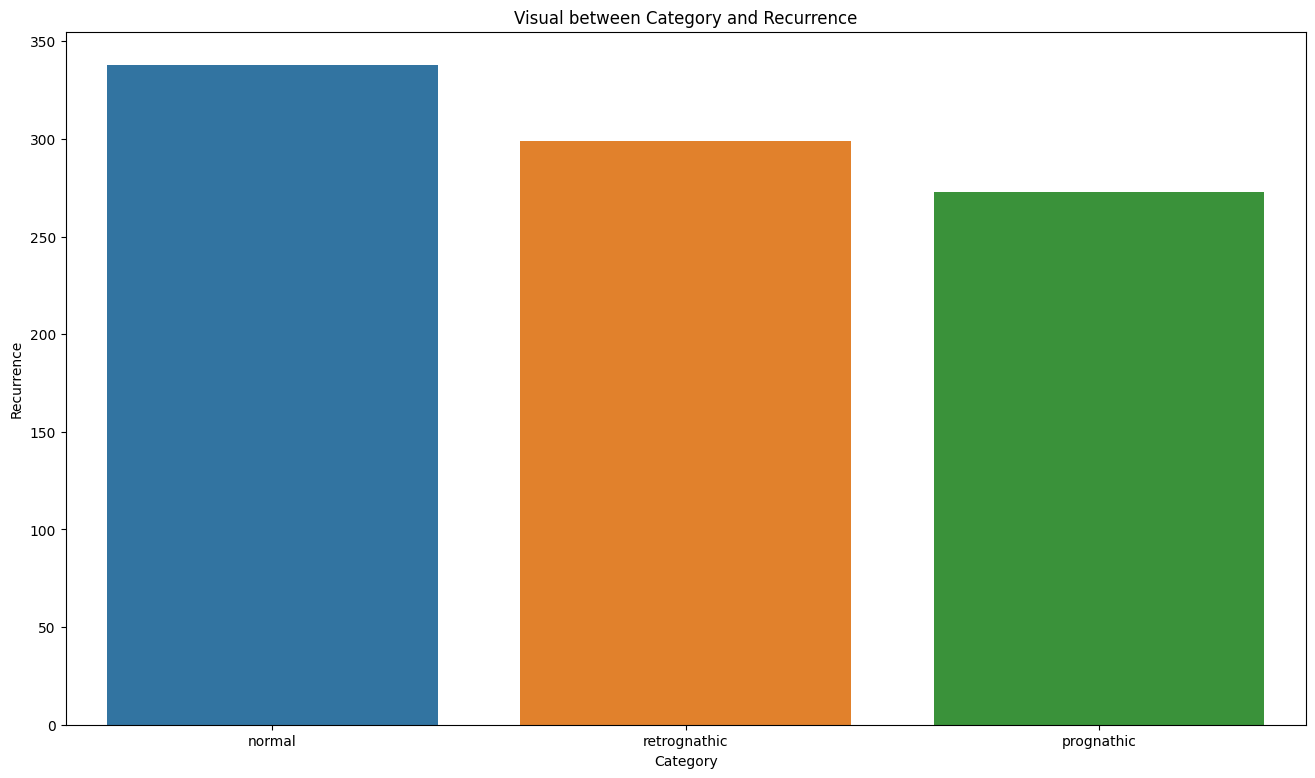

In [18]:
fig, ax =  plt.subplots(figsize =(16, 9)) 
ax.set_title('Visual between Category and Recurrence')
plt.xlabel('Category')
plt.ylabel('Recurrence')
dict_type = dict(sorted(dict_type.items(), key=lambda item: item[1],reverse=True))
dict_seaborn ={}
for category , count in dict_type.items():
    dict_seaborn[category] =count
seaborn.barplot(x=list(dict_seaborn.keys()),y=list(dict_seaborn.values()))
plt.show()

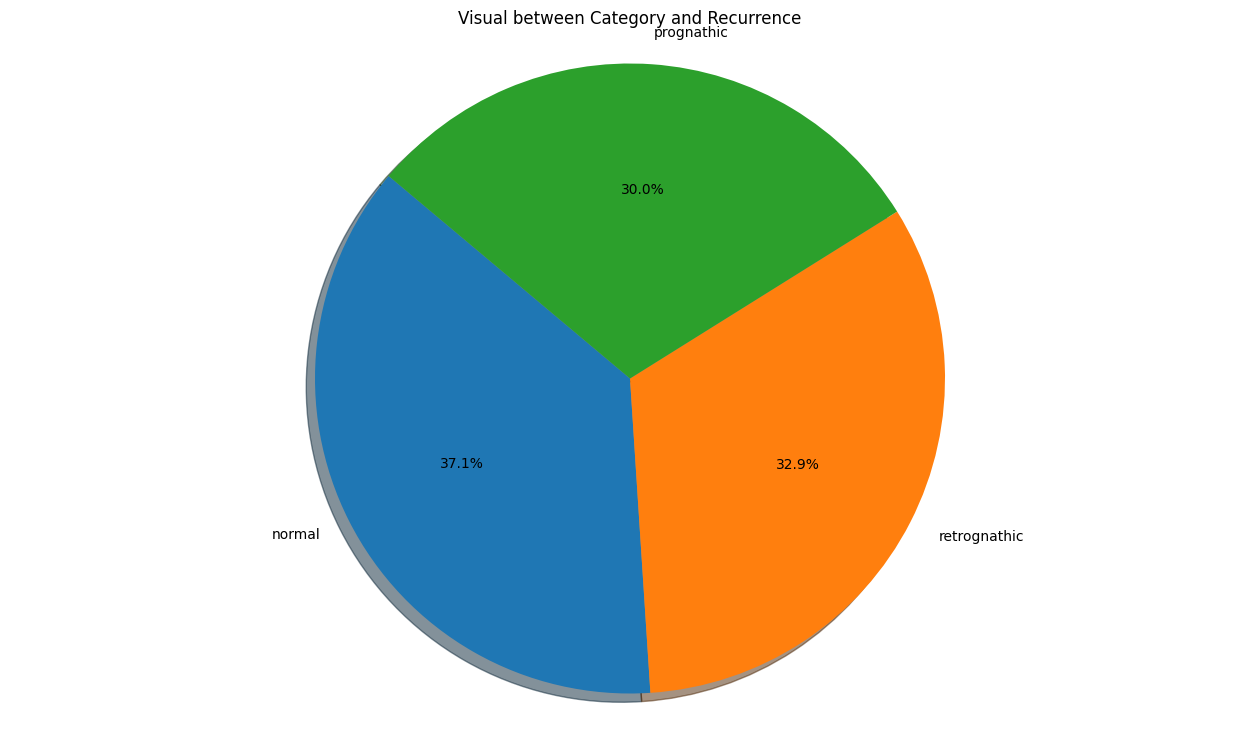

In [19]:
plt.subplots(figsize =(16, 9)) 
plt.title('Visual between Category and Recurrence')
labels = dict_seaborn.keys()
sizes = dict_seaborn.values()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [20]:
print("Answer :It becomes clear to us that the category owner of the highest recurrence is "+list(dict_type.keys())[0]+" which amounts to his recurrence {} .".format(list(dict_type.values())[0]))

Answer :It becomes clear to us that the category owner of the highest recurrence is normal which amounts to his recurrence 338 .


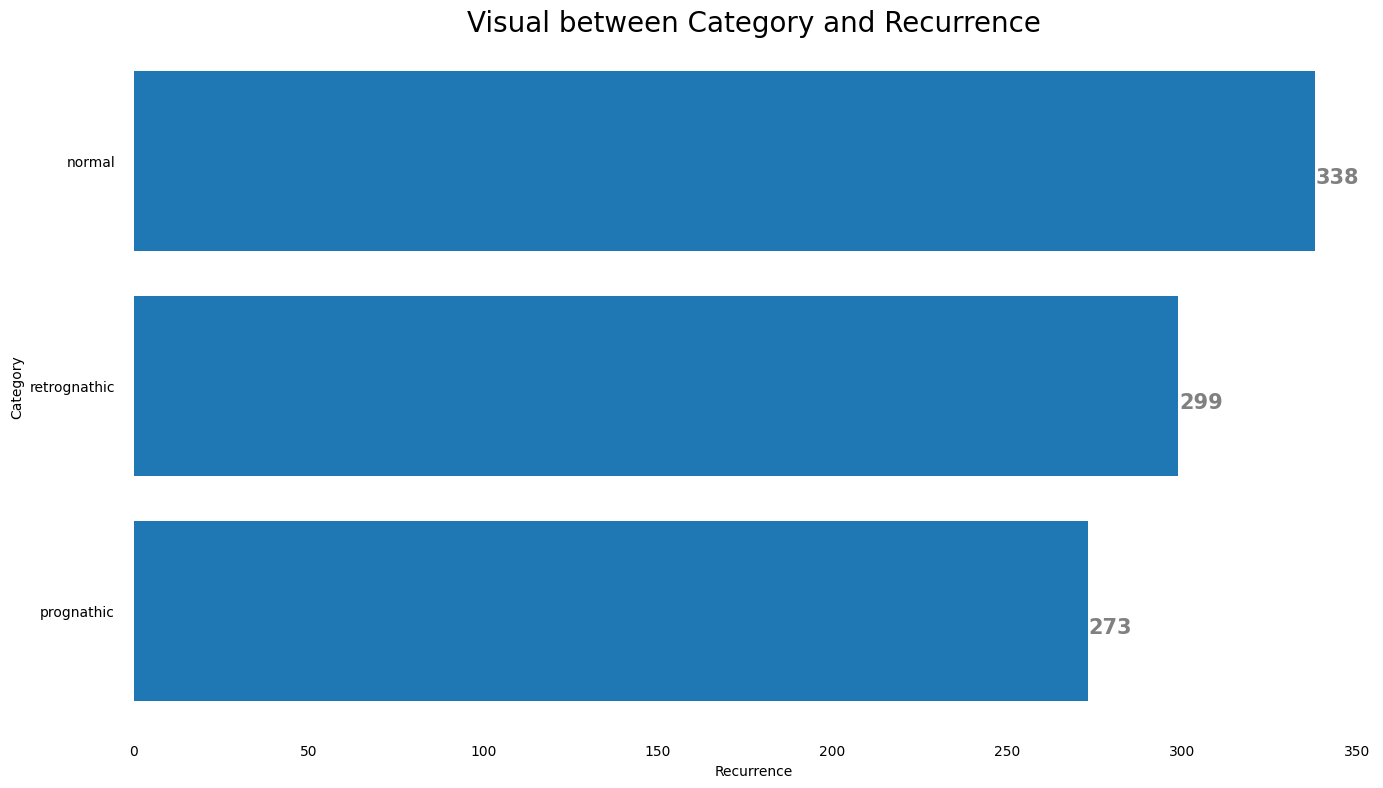

In [21]:
category = list(dict_seaborn.keys())
count = list(dict_seaborn.values())
  
fig, ax = plt.subplots(figsize =(16, 9)) 
ax.barh(category, count) 
  
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 
  
ax.invert_yaxis() 
  
for i in ax.patches: 
    plt.text(i.get_width()+0.2, i.get_y()+0.5,  
             str(round((i.get_width()), 2)), 
             fontsize = 15, fontweight ='bold', 
             color ='grey') 
plt.xlabel('Recurrence')
plt.ylabel('Category')
ax.set_title('Visual between Category and Recurrence', fontsize=20)
# Show Plot 
plt.show(); 

<a id='pre'></a>
## Preprocessing DataSet

## We will split each of dataframe to three dataframe ( Train , Validate , Test)
#### Train 80%
#### Valid 10%
#### Test 10%

### We will split data of faces

In [22]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(train_data_frame,random_state=10, test_size=0.1)
train_df, test_df = train_test_split(train_df,random_state=10, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()
test_df = test_df.reset_index()


total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]

In [23]:
total_train,total_validate,total_test

(737, 91, 82)

In [24]:
print(len(validate_df[validate_df['category']=='0']))
print(len(validate_df[validate_df['category']=='1']))
print(len(validate_df[validate_df['category']=='2']))

28
29
34


<a id='cnn'></a>
## CNN Model

<a id='aug'></a>
## Data Augmentation

<a id='apply'></a>
## Apply

In [25]:
image_size = 224
input_shape = (image_size, image_size, 3)

batch_size = 5

In [26]:
1016//10

101

In [27]:
# https://towardsdatascience.com/image-data-augmentation-for-deep-learning-77a87fabd2bf
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    y_col='category',

    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 737 validated image filenames belonging to 3 classes.


In [28]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
     
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

test_generator = validation_datagen.flow_from_dataframe(
    test_df, 
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    shuffle=False
)


Found 91 validated image filenames belonging to 3 classes.
Found 82 validated image filenames belonging to 3 classes.


<a id='demo'></a>
## Demo

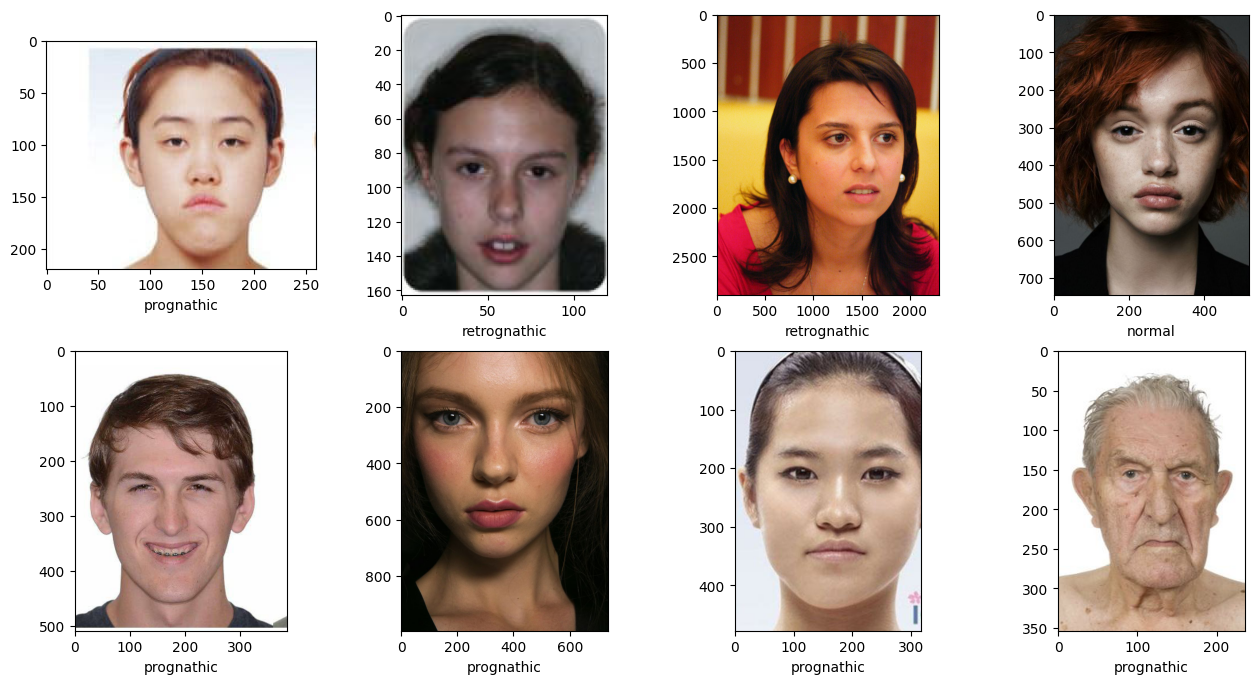

In [29]:
nrows = 2
ncols = 4
fig = plt.gcf() # get current figure
fig.set_size_inches(ncols * 4, nrows * 4) # change the size of the figure
for i in range(8):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    plt.xlabel(le.classes_[int(train_data_frame['category'][i])])
    #sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(train_data_frame['filename'][i])
    plt.imshow(img)

plt.show()

Found 1 validated image filenames belonging to 1 classes.


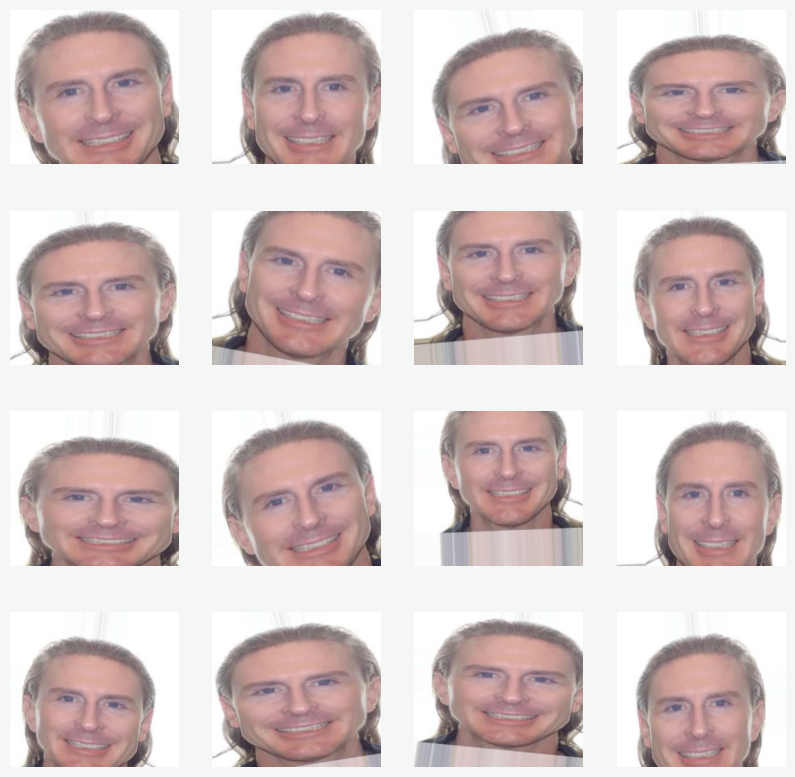

In [30]:
import matplotlib.pyplot as plt
def data_argumentation_show(n, grid_size):
    sample_data = train_datagen.flow_from_dataframe(
            (train_df.sample(n)),
            x_col = 'filename',
            y_col = 'category',
            target_size = (224, 244),
            class_mode = 'categorical')
  
  #subplot grid 
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
    fig.show()
data_argumentation_show(1,4)


In [31]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

'''
        monitor: quantity to be monitored.
        factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
        patience: number of epochs with no improvement after which learning rate will be reduced.
        verbose: int. 0: quiet, 1: update messages.
        mode: one of {'auto', 'min', 'max'}. In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.
        min_delta: threshold for measuring the new optimum, to only focus on significant changes.
        cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
        min_lr: lower bound on the learning rate.
'''

def myCallbacks(weights_name):
    #Reduce learning rate when a metric has stopped improving.
    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy', 
        patience=2, 
        verbose=1, 
        factor=0.2, 
        min_lr=0.0001,
        )
    es=EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01,
        patience=8,
        verbose=1,
        mode="auto",
    )
    '''
    model_cp=ModelCheckpoint(
        filepath=str(weights_name)+".h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    '''
    callbacks = [es, learning_rate_reduction]
    return callbacks

In [32]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',classes = np.unique(train_generator.classes),y = train_generator.classes)
cw = dict(zip( np.unique(train_generator.classes), weights))
print(cw)

{0: 0.8933333333333333, 1: 1.1166666666666667, 2: 1.0151515151515151}


<a id='build'></a>
## Model Building

<a id='scrath'></a>
## Model EfficientNetB3


In [ ]:

def make_model():
    '''
    include_top: Whether to include the fully-connected layer at the top of the network. Defaults to True.
    weights: One of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded. Defaults to 'imagenet'.
    input_tensor: Optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
    input_shape: Optional shape tuple, only to be specified if include_top is False. It should have exactly 3 inputs channels.
    pooling: Optional pooling mode for feature extraction when include_top is False. Defaults to None. - None means that the output of the model will be the 4D tensor output of the last convolutional layer. - avg means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor. - max means that global max pooling will be applied.
    classes: Optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified. Defaults to 1000 (number of ImageNet classes).
    classifier_activation: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. Defaults to 'softmax'. When loading pretrained weights, classifier_activation can only be None or "softmax".
    '''
    effnet = EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 
    effnet.trainable=False
    # https://www.researchgate.net/figure/Architecture-of-Efficient-Net-B3_tbl1_355378056
    for layer in effnet.layers[83:]:
        layer.trainable=True
    
    x = effnet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
                    
    x = Dropout(rate=.45, seed=2022)(x)        
    output=Dense(3, activation='softmax')(x)
    
    model= keras.Model(inputs=effnet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='categorical_crossentropy', metrics=['accuracy']) 
    return model


In [ ]:
model = make_model()
# model.summary()

In [ ]:
history =model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=myCallbacks('EfficientNetB3')
)

Epoch 1/15


2023-06-09 13:24:13.322377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 [==============================] - 78s 176ms/step - loss: 21.5617 - accuracy: 0.3907 - val_loss: 19.6098 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 2/15
147/147 [==============================] - 22s 146ms/step - loss: 17.3408 - accuracy: 0.4057 - val_loss: 15.2200 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 3/15
147/147 [==============================] - 22s 146ms/step - loss: 14.1881 - accuracy: 0.4426 - val_loss: 12.5075 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 4/15
147/147 [==============================] - 22s 151ms/step - loss: 11.6799 - accuracy: 0.4454 - val_loss: 10.9433 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 5/15
147/147 [==============================] - 22s 146ms/step - loss: 9.5010 - accuracy: 0.5082 - val_loss: 8.2176 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 6/15
147/147 [==============================] - 21s 143ms/step - loss: 7.6140 - accuracy: 0.5109 - val_loss: 6.8984 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/15
147/147 [==============================] - 2

In [ ]:
history =model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=myCallbacks('EfficientNetB3')
)

Epoch 1/15
147/147 [==============================] - 21s 145ms/step - loss: 1.3808 - accuracy: 0.7104 - val_loss: 1.5175 - val_accuracy: 0.6889 - lr: 2.0000e-04
Epoch 2/15
147/147 [==============================] - 22s 147ms/step - loss: 1.3194 - accuracy: 0.7117 - val_loss: 1.3810 - val_accuracy: 0.7556 - lr: 2.0000e-04
Epoch 3/15
147/147 [==============================] - 22s 147ms/step - loss: 1.2739 - accuracy: 0.7268 - val_loss: 1.3762 - val_accuracy: 0.7444 - lr: 2.0000e-04
Epoch 4/15
147/147 [==============================] - ETA: 0s - loss: 1.2096 - accuracy: 0.7363
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001.
147/147 [==============================] - 21s 145ms/step - loss: 1.2096 - accuracy: 0.7363 - val_loss: 1.3103 - val_accuracy: 0.7556 - lr: 2.0000e-04
Epoch 5/15
147/147 [==============================] - 22s 152ms/step - loss: 1.1775 - accuracy: 0.7514 - val_loss: 1.2445 - val_accuracy: 0.7556 - lr: 1.0000e-04
Epoch 6/15
147/147 [========================

In [ ]:
history =model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=myCallbacks('EfficientNetB3')
)

Epoch 1/15
147/147 [==============================] - 23s 153ms/step - loss: 0.9594 - accuracy: 0.8019 - val_loss: 1.0476 - val_accuracy: 0.7889 - lr: 1.0000e-04
Epoch 2/15
147/147 [==============================] - 21s 144ms/step - loss: 0.9481 - accuracy: 0.8019 - val_loss: 1.0676 - val_accuracy: 0.7889 - lr: 1.0000e-04
Epoch 3/15
147/147 [==============================] - 22s 152ms/step - loss: 0.9484 - accuracy: 0.8128 - val_loss: 0.9722 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 4/15
147/147 [==============================] - 22s 149ms/step - loss: 0.9057 - accuracy: 0.8156 - val_loss: 1.0186 - val_accuracy: 0.8111 - lr: 1.0000e-04
Epoch 5/15
147/147 [==============================] - 22s 146ms/step - loss: 0.9067 - accuracy: 0.8033 - val_loss: 0.9905 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 6/15
147/147 [==============================] - 22s 151ms/step - loss: 0.9082 - accuracy: 0.8060 - val_loss: 0.9768 - val_accuracy: 0.8111 - lr: 1.0000e-04
Epoch 7/15
147/147 [========

In [ ]:
history =model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=myCallbacks('EfficientNetB3')
)

Epoch 1/15
147/147 [==============================] - 22s 152ms/step - loss: 0.7754 - accuracy: 0.8443 - val_loss: 0.8889 - val_accuracy: 0.8222 - lr: 1.0000e-04
Epoch 2/15
147/147 [==============================] - 22s 148ms/step - loss: 0.7648 - accuracy: 0.8470 - val_loss: 0.7772 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 3/15
147/147 [==============================] - 22s 147ms/step - loss: 0.7334 - accuracy: 0.8607 - val_loss: 0.8223 - val_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 4/15
147/147 [==============================] - 21s 144ms/step - loss: 0.7695 - accuracy: 0.8251 - val_loss: 0.8391 - val_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 5/15
147/147 [==============================] - 22s 151ms/step - loss: 0.7579 - accuracy: 0.8279 - val_loss: 0.7879 - val_accuracy: 0.8556 - lr: 1.0000e-04
Epoch 6/15
147/147 [==============================] - 22s 149ms/step - loss: 0.7285 - accuracy: 0.8525 - val_loss: 0.7329 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 7/15
147/147 [========

In [ ]:
test_accu = model.evaluate(test_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

17/17 [==============================] - 1s 57ms/step - loss: 0.8411 - accuracy: 0.8293
The testing accuracy is : 82.92682766914368 %


<a id='scrath'></a>
## Model EfficientNetB3T


In [ ]:
effnet = EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 
    # https://www.researchgate.net/figure/Architecture-of-Efficient-Net-B3_tbl1_355378056
for layer in effnet.layers:
    layer.trainable=True
model_effnet= Sequential()
model_effnet.add(effnet)
model_effnet.add(Flatten())
model_effnet.add(Dense(512,activation='relu'))
model_effnet.add(Dense(3, activation='softmax'))
model_effnet.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
model_effnet.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 flatten_8 (Flatten)         (None, 1536)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               786944    
                                                                 
 dense_21 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 11,572,018
Trainable params: 11,484,715
Non-trainable params: 87,303
_________________________________________________________________


In [ ]:
epochs = 20
historymodel_effnet = model_effnet.fit(train_generator,
 steps_per_epoch=total_train//batch_size,
 validation_data=validation_generator,
 verbose=1,
 validation_steps=total_validate//batch_size,
 epochs=epochs,callbacks=myCallbacks('model_effnet'))

test_accu = model_effnet.evaluate(test_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

Epoch 1/20


2023-06-09 15:07:41.140857: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 [==============================] - 93s 178ms/step - loss: 2.1543 - accuracy: 0.4617 - val_loss: 1.0934 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/20
147/147 [==============================] - 23s 159ms/step - loss: 0.8330 - accuracy: 0.6202 - val_loss: 1.1121 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 0.7687 - accuracy: 0.6790
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
147/147 [==============================] - 23s 158ms/step - loss: 0.7687 - accuracy: 0.6790 - val_loss: 1.3745 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
147/147 [==============================] - 24s 163ms/step - loss: 0.6075 - accuracy: 0.7459 - val_loss: 0.9322 - val_accuracy: 0.5556 - lr: 2.0000e-04
Epoch 5/20
147/147 [==============================] - 24s 163ms/step - loss: 0.4904 - accuracy: 0.8251 - val_loss: 0.8345 - val_accuracy: 0.6111 - lr: 2.0000e-04
Epoch 6/20
147/147 [==============================]

 <a id='MobileNet'></a>
## Model MobileNet  

# <a id='trainMobileNet'></a>
## Model MobileNet (  trainable  )    

In [33]:
import tensorflow as tf


input_shape = (224,224,3)
MobileNet= tf.keras.applications.MobileNet(include_top=False,input_shape=input_shape,pooling
='avg',classes=3,weights='imagenet')
model_MobileNet = Sequential()
model_MobileNet.add(MobileNet)
model_MobileNet.add(Flatten())
model_MobileNet.add(Dense(512, activation='relu'))
model_MobileNet.add(Dense(3, activation='softmax'))
model_MobileNet.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics=[
"accuracy"])
model_MobileNet.summary()

17225924/17225924 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 3,755,203
Trainable params: 3,733,315
Non-trainable params: 21,888
_________________________________________________________________


In [34]:
epochs = 20
historyMobileNet = model_MobileNet.fit(train_generator,
 steps_per_epoch=total_train//batch_size,
 validation_data=validation_generator,
 verbose=1,
 validation_steps=total_validate//batch_size,
 epochs=epochs,callbacks=myCallbacks('mobilenet'))

Epoch 1/20
147/147 [==============================] - 224s 1s/step - loss: 1.1394 - accuracy: 0.5505 - val_loss: 0.8801 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 2/20
147/147 [==============================] - 181s 1s/step - loss: 0.7763 - accuracy: 0.6612 - val_loss: 0.8308 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 3/20
147/147 [==============================] - 181s 1s/step - loss: 0.6881 - accuracy: 0.7295 - val_loss: 1.1341 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 4/20
147/147 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.6926
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
147/147 [==============================] - 180s 1s/step - loss: 0.7062 - accuracy: 0.6926 - val_loss: 1.0103 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/20
147/147 [==============================] - 180s 1s/step - loss: 0.5158 - accuracy: 0.7964 - val_loss: 0.4163 - val_accuracy: 0.8444 - lr: 2.0000e-04
Epoch 6/20
147/147 [==============================] - 

In [35]:
test_accu = model_MobileNet.evaluate(test_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

3/3 [==============================] - 4s 1s/step - loss: 0.4097 - accuracy: 0.8780
The testing accuracy is : 87.80487775802612 %


In [ ]:
model_MobileNet.save("model_MobileNet.h5")

<a id='scratchComplex'></a>
## Model resNet50OLD

In [ ]:

def make_model1():
    resNet = keras.applications.ResNet50(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 
    resNet.trainable=False
    
    for layer in resNet.layers[83:]:
      layer.trainable=True
    
    x = resNet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)        
    output=Dense(3, activation='softmax')(x)
    
    model= keras.Model(inputs=resNet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='categorical_crossentropy', metrics=['accuracy']) 
    return model


In [ ]:
model2 = make_model1()

In [ ]:
history2 =model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
    #callbacks=myCallbacks('ResNet50')
)

Epoch 1/25

163/163 [==============================] - 30s 186ms/step - loss: 22.9710 - accuracy: 0.4066 - val_loss: 70.8655 - val_accuracy: 0.4889

Epoch 2/25

163/163 [==============================] - 28s 172ms/step - loss: 18.1408 - accuracy: 0.4017 - val_loss: 42.0913 - val_accuracy: 0.2667

Epoch 3/25

163/163 [==============================] - 28s 174ms/step - loss: 13.9082 - accuracy: 0.4184 - val_loss: 58.8223 - val_accuracy: 0.4444

Epoch 4/25

163/163 [==============================] - 26s 159ms/step - loss: 10.5110 - accuracy: 0.4595 - val_loss: 40.4006 - val_accuracy: 0.4889

Epoch 5/25

163/163 [==============================] - 32s 197ms/step - loss: 8.0332 - accuracy: 0.4877 - val_loss: 50.2915 - val_accuracy: 0.2667

Epoch 6/25

163/163 [==============================] - 30s 183ms/step - loss: 6.1214 - accuracy: 0.5037 - val_loss: 36.0465 - val_accuracy: 0.3000

Epoch 7/25

163/163 [==============================] - 31s 188ms/step - loss: 4.6525 - accuracy: 0.4939 - va

<a id='scratchComplex'></a>
## Model resnet50New

In [ ]:
input_shape = (224,224,3)
ResNet152V2= tf.keras.applications.ResNet152V2(include_top=False, weights="imagenet", input_shape=input_shape)
for layer in ResNet152V2.layers:
        layer.trainable=False
model_ResnetF = Sequential()
model_ResnetF.add(ResNet152V2)
model_ResnetF.add(Flatten())
model_ResnetF.add(Dense(512, activation='relu'))
model_ResnetF.add(Dense(3, activation='softmax'))
model_ResnetF.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
model_ResnetF.summary()

234545216/234545216 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 512)               51380736  
                                                                 
 dense_11 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 109,713,923
Trainable params: 51,382,275
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
epochs = 15
historyResnetF = model_ResnetF.fit(train_generator,
 steps_per_epoch=total_train//batch_size,
 validation_data=validation_generator,
 verbose=1,
 validation_steps=total_validate//batch_size,
 epochs=epochs,callbacks=myCallbacks('resnet'))


test_accu = model_ResnetF.evaluate(test_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

Epoch 1/15
147/147 [==============================] - 33s 147ms/step - loss: 8.6215 - accuracy: 0.5287 - val_loss: 0.9807 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/15
147/147 [==============================] - 19s 128ms/step - loss: 0.8669 - accuracy: 0.6557 - val_loss: 0.7597 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/15
147/147 [==============================] - 19s 130ms/step - loss: 0.7709 - accuracy: 0.6817 - val_loss: 0.9291 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 4/15
147/147 [==============================] - 19s 130ms/step - loss: 0.7082 - accuracy: 0.7077 - val_loss: 0.7657 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 5/15
147/147 [==============================] - 19s 129ms/step - loss: 0.6533 - accuracy: 0.7281 - val_loss: 0.6649 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/15
147/147 [==============================] - 18s 125ms/step - loss: 0.6705 - accuracy: 0.7500 - val_loss: 0.7970 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 7/15
147/147 [==============================] 

<a id='scratchComplex'></a>
## Model VGG16

In [ ]:
input_shape = (224,224,3)
VGG16= tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
model_VGG16F= Sequential()
for layer in VGG16.layers:
    layer.trainable = False
model_VGG16F.add(VGG16)
model_VGG16F.add(Conv2D(64, (3, 3), activation = 'relu'))
model_VGG16F.add(MaxPooling2D(pool_size = (2, 2)))
model_VGG16F.add(Dropout(0.10))
model_VGG16F.add(Flatten())
model_VGG16F.add(Dense(128,activation='relu'))
model_VGG16F.add(Dropout(0.10))
model_VGG16F.add(Dense(3, activation='softmax'))
model_VGG16F.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
model_VGG16F.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 5, 64)          294976    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               

In [ ]:
epochs = 15

historyVGG16F = model_VGG16F.fit(train_generator,
 steps_per_epoch=total_train//batch_size,
 validation_data=validation_generator,
 verbose=1,
 validation_steps=total_validate//batch_size,
 epochs=epochs,callbacks=myCallbacks('vgg16'))


test_accu = model_VGG16F.evaluate(test_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

Epoch 1/15
147/147 [==============================] - 18s 124ms/step - loss: 0.4580 - accuracy: 0.8183 - val_loss: 0.6254 - val_accuracy: 0.7556 - lr: 1.0000e-04
Epoch 2/15
147/147 [==============================] - 18s 120ms/step - loss: 0.4347 - accuracy: 0.8183 - val_loss: 0.6380 - val_accuracy: 0.7444 - lr: 1.0000e-04
Epoch 3/15
147/147 [==============================] - 18s 121ms/step - loss: 0.4445 - accuracy: 0.8115 - val_loss: 0.6293 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 4/15
147/147 [==============================] - 18s 123ms/step - loss: 0.4065 - accuracy: 0.8238 - val_loss: 0.6018 - val_accuracy: 0.7556 - lr: 1.0000e-04
Epoch 5/15
147/147 [==============================] - 18s 124ms/step - loss: 0.4084 - accuracy: 0.8347 - val_loss: 0.6066 - val_accuracy: 0.7556 - lr: 1.0000e-04
Epoch 6/15
147/147 [==============================] - 18s 122ms/step - loss: 0.4038 - accuracy: 0.8538 - val_loss: 0.5686 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 7/15
147/147 [========

In [ ]:
test_accu = model_VGG16F.evaluate(test_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

17/17 [==============================] - 1s 67ms/step - loss: 0.6130 - accuracy: 0.6951
The testing accuracy is : 69.51219439506531 %


load best model

In [33]:
model_MobileNet = tf.keras.models.load_model('/content/model_MobileNet92.h5')

<a id='perf'></a>
##best Model Performance(mobile net)

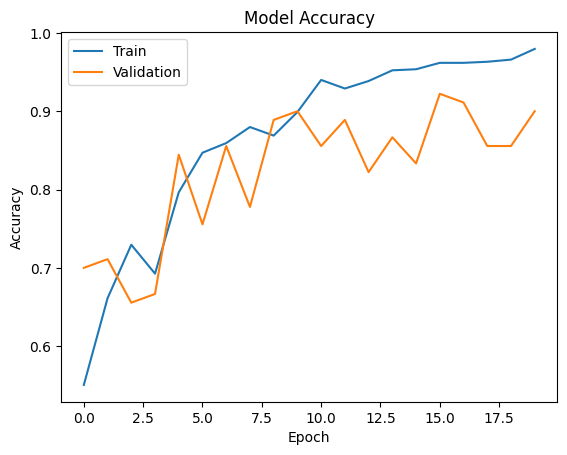

In [36]:
plt.plot(historyMobileNet.history['accuracy'])
plt.plot(historyMobileNet.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

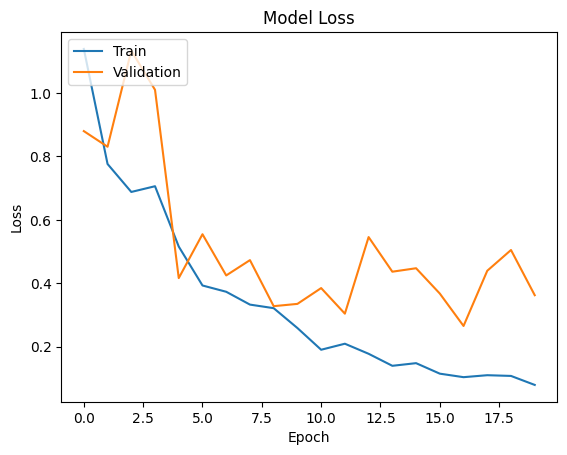

In [37]:
plt.plot(historyMobileNet.history['loss'])
plt.plot(historyMobileNet.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

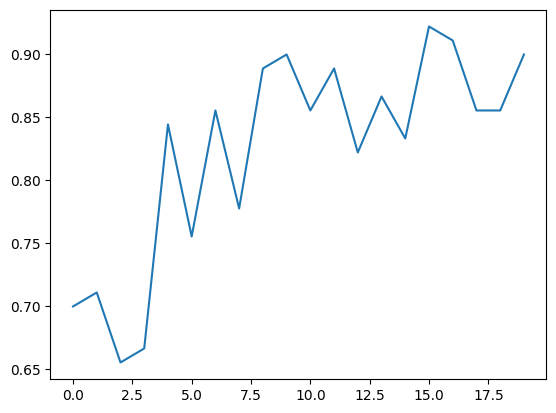

In [38]:
plt.plot(historyMobileNet.history['val_accuracy'])

In [34]:
np.argmax( model_MobileNet.predict(test_generator),axis=1)

3/3 [==============================] - 6s 1s/step


array([2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0,
       2, 1, 2, 0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2, 0, 2, 1,
       1, 2, 0, 1, 1, 2, 0, 2, 2, 1, 0, 2, 0, 1, 2, 0])

In [35]:
model_MobileNet.evaluate(test_generator)

3/3 [==============================] - 10s 3s/step - loss: 0.0596 - accuracy: 0.9756


[0.059578727930784225, 0.9756097793579102]

In [40]:
import seaborn as sns

In [41]:
from sklearn.metrics import confusion_matrix,classification_report
def predict_image(image_path,model):
    
  
    image=cv2.imread(str(image_path))
    imageee=cv2.resize(image,(224,224))
    imageee=cv2.cvtColor(imageee,cv2.COLOR_BGR2RGB)
    imageee=imageee/255.0
    res= model.predict(np.array([imageee]))
    return np.argmax(res)


In [42]:
#predict_image("/content/retrognathic.jpg")

In [43]:

#predict_image("/kaggle/input/retrognathic/retrognathic.jpg")

In [36]:
idx2label_dict = {test_generator.class_indices[k]: k for k in test_generator.class_indices}
idx2label_dict

{0: '0', 1: '1', 2: '2'}

199it [02:40,  1.24it/s]


172/172 [==============================] - 254s 1s/step
confusion matrix :
 [[2272    0   67]
 [   0 1536   67]
 [   0  134 1400]]
confusion matrix :
 [[2272    0   67]
 [   0 1536   67]
 [   0  134 1400]]
Precision Score :  0.9510591672753835
Recall Score :  0.9510591672753835
classification_report :
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      2339
           1       0.92      0.96      0.94      1603
           2       0.91      0.91      0.91      1534

    accuracy                           0.95      5476
   macro avg       0.94      0.95      0.95      5476
weighted avg       0.95      0.95      0.95      5476



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


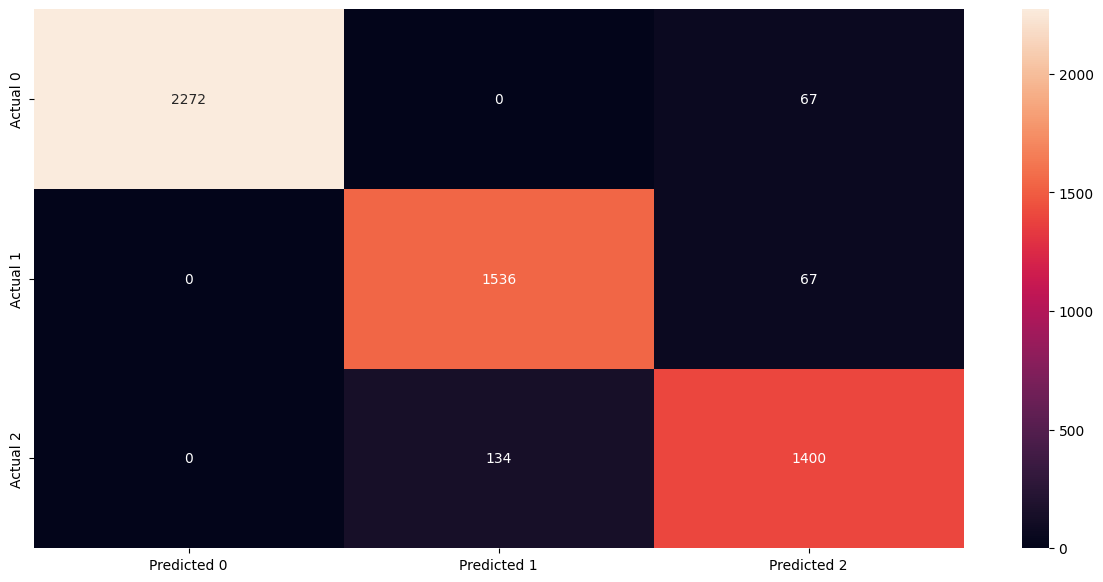

In [34]:
from tqdm import tqdm
imgs=[]
y_true=[]
x=0
for img, label in tqdm(test_generator):
    imgs.append(img)
    y_true.append(label)
    x+=1;
    if(x==200):
      break


imgs = tf.concat(imgs, axis=0)    
y_true = np.argmax(tf.concat(y_true, axis=0), axis=1)

y_pred = np.argmax(model_MobileNet.predict(imgs), axis=1)
print ('confusion matrix :\n',confusion_matrix(y_true,y_pred))

#predict_x=model_MobileNet.predict(test_generator) 
#y_pred=np.argmax(predict_x,axis=1)
idx2label_dict = {test_generator.class_indices[k]: k for k in test_generator.class_indices}
#y_true = test_generator.classes


plt.figure(figsize = (15,7))

cm = pd.DataFrame(data=confusion_matrix(y_true, y_pred, labels=[0, 1,2]),
                  
                  index=["Actual " + idx2label_dict[0],
                         "Actual " + idx2label_dict[1],
                         "Actual " + idx2label_dict[2],
                  ],
                  
                  columns=["Predicted "+ idx2label_dict[0],
                           "Predicted "+ idx2label_dict[1],
                           "Predicted "+ idx2label_dict[2],
                           ])

seaborn.heatmap(cm,annot=True,fmt="d");

#test_accuracy = model_MobileNet.evaluate(testRgb)
#print('The testing accuracy is :',test_accuracy[1]*100, '%')
print('confusion matrix :\n',confusion_matrix(y_true,y_pred))
print("Precision Score : ",precision_score(y_true, y_pred, pos_label='positive',average='micro'))
print("Recall Score : ",recall_score(y_true, y_pred, pos_label='positive',average='micro'))
print('classification_report :\n',classification_report(y_true,y_pred))

172/172 [==============================] - 268s 2s/step


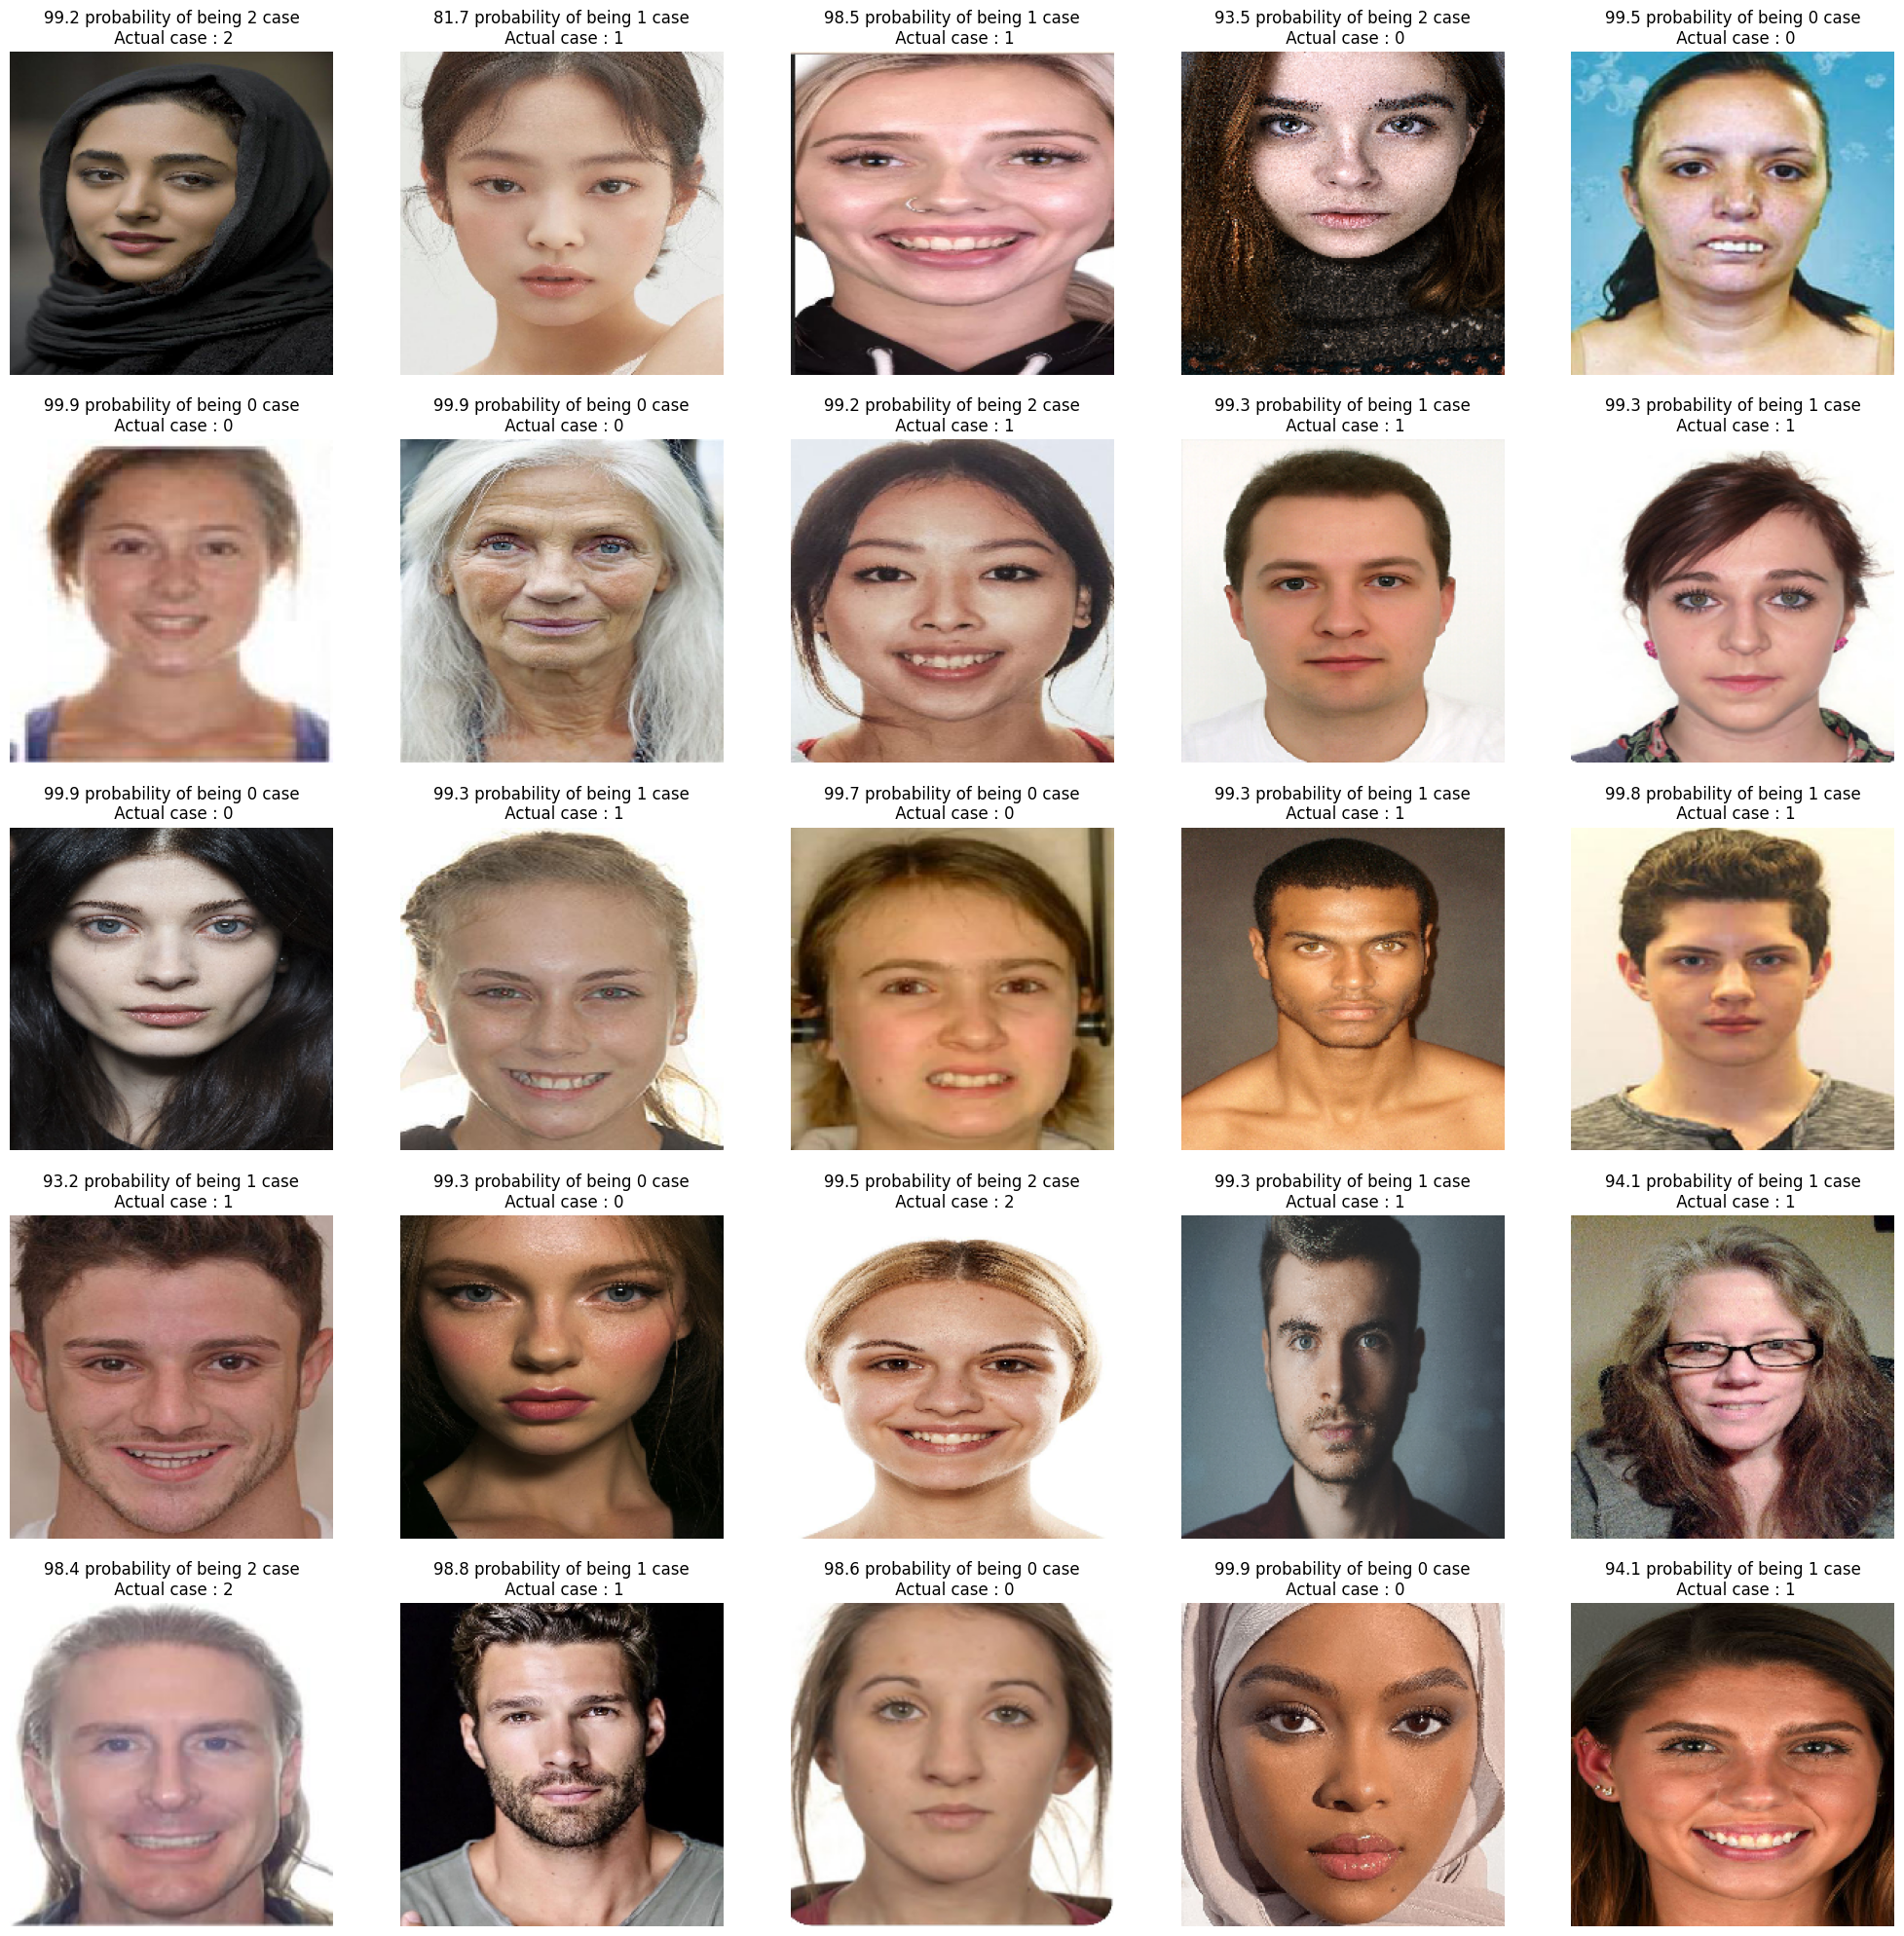

In [40]:
predict_x=model_MobileNet.predict(imgs)
plt.figure(figsize=(25,25))
randomlist = random.sample(range(0, 200), 25)
index_list = 0
for i in range(0+228, 25+228):
        plt.subplot(5, 5, (i-228)+1)
        #print(predict_x[randomlist[index_list]])
        index = np.argmax(predict_x[randomlist[index_list]],axis=0)
        out = str(predict_x[randomlist[index_list]][index]*100)[:4] + ' probability of being '+idx2label_dict[y_pred[randomlist[index_list]]]+' case'
        #print(y_pred[randomlist[index_list]] ,index , predict_x[randomlist[index_list]][index])
        plt.title(out+"\n Actual case : "+ idx2label_dict.get(y_true[randomlist[index_list]]))    
        plt.imshow(np.squeeze(imgs[index_list]))
        plt.axis('off')
        index_list = index_list + 1
plt.show()

In [ ]:
img = cv2.imread('/content/retrognathic.jpg')
img = cv2.resize(img,dsize=(224,224),interpolation=cv2.INTER_CUBIC)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_arr = tf.keras.preprocessing.image.img_to_array(gray)
input_arr = np.array([input_arr]) 
input_arr = input_arr.astype('float32') / 255.  
predictions = model_MobileNet.predict(input_arr)
print(np.argmax(predictions,axis=1)   ,predictions)
print(np.argmax(predictions,axis=1)   ,predictions[0]*100)
print(np.argmax(predictions,axis=1)   ,predictions[0][1]*100)

<a id='tensor'></a>
## Convert Model Keras To TensorFlow

In [ ]:
from tensorflow import keras
from tensorflow import lite
saved_model_dir = '/content/model_MobileNetCa.h5'
model = keras.models.load_model(saved_model_dir)
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/model_mobileNetCA97.tflite","wb").write(tflite_model)

In [ ]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="./MobileNetT.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

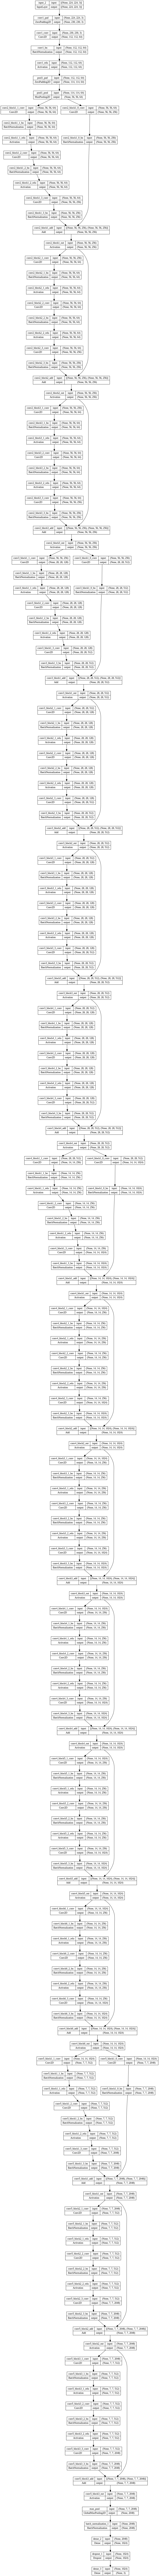

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn.png', show_shapes=True)